## Orientation Recovery with Learned Distances

In [1]:
ROOT_DIR = "../.."

In [2]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
import os
import h5py
import numpy as np   
import matplotlib.pyplot as plt
import sys
sys.path.append(ROOT_DIR) 
from cryoem.conversions import euler2quaternion, d_q
from cryoem.angle_recovery import train_angle_recovery
from cryoem.plots import plot_projection, plot_iterations_polar_plot, plot_iterations_rotvec
from cryoem.helpers import train_val_test_split, projections_preprocessing
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
from cryoem.conversions import quaternion2euler

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11201560202783512305
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11131505856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4109794323341595665
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
]


### Read data

In [5]:
# full sphere coverage 
projections_filename = "../../data/5j0n_full_uniformS2.h5"

# load structures
data_full_5k = h5py.File(projections_filename, 'r')
angles_true = np.array(data_full_5k['Angles'], dtype=np.float32)
projections = np.array(data_full_5k['Projections'], dtype=np.float32)
label = "Full-coverage, Euler uniform"


print(f"{angles_true.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [6]:
train_idx, val_idx, test_idx = train_val_test_split(indices=range(len(projections)), file_name="../../data/indices.npz")

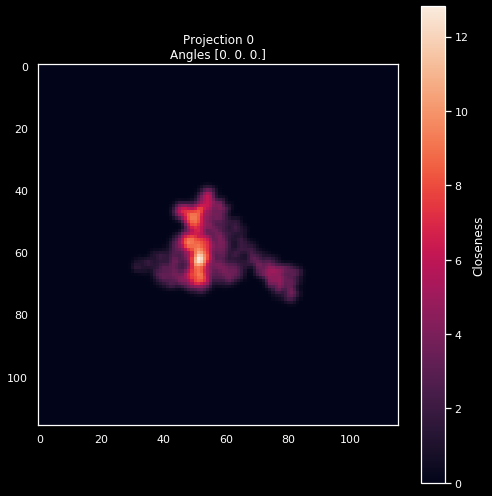

In [7]:
pid = 0
plot_projection(projections[pid], f'Projection {pid}\nAngles {angles_true[pid]}')

In [8]:
settings = dict(
    noise={"variance":16.0},
    shift={"left_limit":-0.01,
           "peak_limit":0,
           "right_limit":0.01},
    channels="gray"
)

In [9]:
X, y = projections_preprocessing(projections, angles_true, settings=settings)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.263 | Std: 4.129
Min:  -24.363 | Max: 27.885
Mean: -0.000 | Std: 1.000
Min:  -5.965 | Max: 6.691


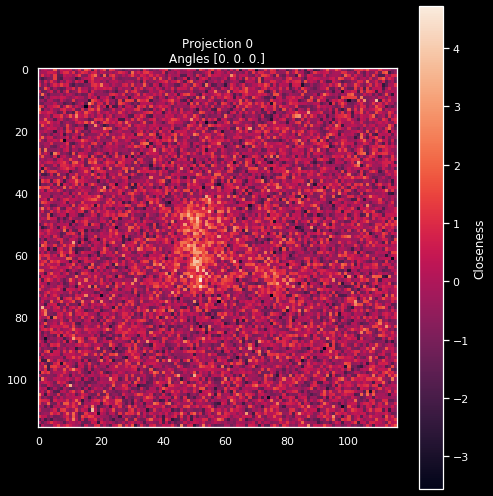

In [10]:
pid = 0
plot_projection(X[pid].squeeze(), f'Projection {pid}\nAngles {y[pid]}')

### Read Model Checkpoint

In [11]:
# put correct filename
model_filename = f"../../data/training/model.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 512)          4551936     input_10[0][0]                   
                                                                 input_11[0][0]                   
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 1)            0           model_6[0][0]              

### Performance Plot - True vs. Predicted

In [12]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

### Orientation Recovery

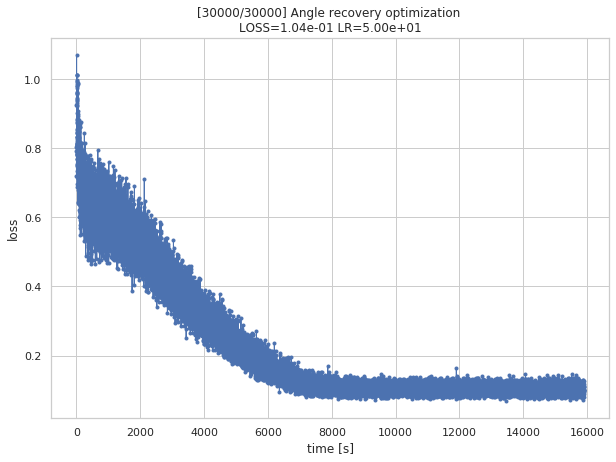

Shape of projections: (1650, 116, 116, 1)step 3000/30000 (1284s): loss = 5.15e-01
step 6000/30000 (2613s): loss = 4.05e-01
step 9000/30000 (4043s): loss = 2.91e-01
step 12000/30000 (5488s): loss = 1.57e-01
step 15000/30000 (7035s): loss = 1.01e-01
step 18000/30000 (8624s): loss = 1.06e-01
step 21000/30000 (10344s): loss = 1.18e-01
step 24000/30000 (12141s): loss = 1.06e-01
step 27000/30000 (14016s): loss = 1.01e-01
step 30000/30000 (15894s): loss = 1.02e-01



In [15]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                             batch_size=256, 
                             in_data=X[test_idx], 
                             distance_fn=d_p, 
                             learning_rate=50, 
                             limit_distance=np.pi,
                             file_name=f"../../data/angle_recovery_with_learned_distance")

In [13]:
data = np.load(f"../../data/angle_recovery_with_learned_distance.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]
angles_predicted = quaternion2euler(q_predicted)

### Angle Alignment

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [5.29445693 2.14386638 4.85138314 0.40389013 0.73004604 6.27717783] 
loss_first= 2.3298074378300395 
trajectory_last= [-22.16350737 -15.98673295  50.24729085   7.25933984  -8.64736822
  12.05868276] 
loss_last= 0.29277362259248785


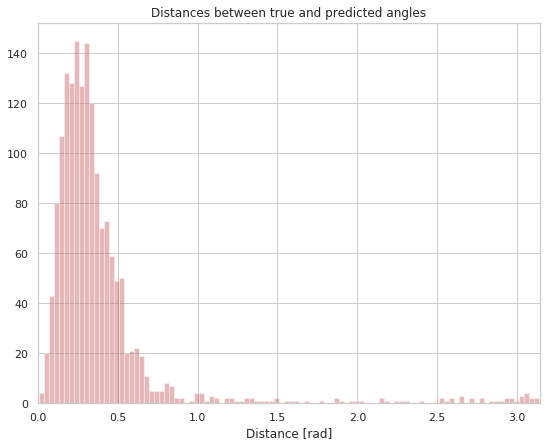

In [17]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true[test_idx], 
                                                        angles_predicted=angles_predicted)

In [21]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

np.save(f"../../data/angles_predicted_with_learned_distance_rotated", angles_predicted_rotated)

In [24]:
plot_iterations_polar_plot(collect_data, angles_true[test_idx], interval=200, connections=False, selected=None)

In [25]:
plot_iterations_rotvec(collect_data, angles_true[test_idx], interval=200)